In [1]:
import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim.lr_scheduler
from torch.autograd import Variable
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2
import pickle
import time
from argparse import ArgumentParser

# Modificar conforme necessario:
import cnn.DataSet as myDataLoader
import cnn.loadData as ld
from cnn import SegmentationModel as net

from cnn.train_utils import train, val, netParams, save_checkpoint, poly_lr_scheduler

import cnn.Transforms as myTransforms
from cnn.IOUEval import iouEval
from livelossplot import PlotLosses
liveloss = PlotLosses()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('CUDA ok' if device == 'cuda' else 'CUDA not ok')

CUDA ok


In [2]:
def trainValidateSegmentation(args):
    '''
    Main function for trainign and validation
    :param args: global arguments
    :return: None
    '''
    
    # load the model
    cuda_available = torch.cuda.is_available()
    num_gpus = torch.cuda.device_count()
    model = net.EESPNet_Seg(args.classes, s=args.s, pretrained=args.pretrained, gpus=num_gpus)

    # create the directory if not exist
    if not os.path.exists(args.savedir):
        os.mkdir(args.savedir)

    # check if processed data file exists or not
    if True or not os.path.isfile(args.cached_data_file):
        dataLoad = ld.LoadData(args.data_dir, args.classes, args.cached_data_file)
        data = dataLoad.processData()
        if data is None:
            print('Error while pickling data. Please check.')
            exit(-1)
    else:
        data = pickle.load(open(args.cached_data_file, "rb"))



    if cuda_available:
        args.onGPU = True
        model = model.cuda()

    total_paramters = netParams(model)
    print('Total network parameters: ' + str(total_paramters))

    # define optimization criteria
    weight = torch.from_numpy(data['classWeights']) # convert the numpy array to torch
    if args.onGPU:
        weight = weight.cuda()

    criteria = torch.nn.MSELoss()

    if args.onGPU:
        criteria = criteria.cuda()
        
    print('Data statistics')
    print(data['mean'], data['std'])
    print(data['classWeights'])

    #compose the data with transforms
    trainDataset = myTransforms.Compose([
        myTransforms.RandomFlip(),
        myTransforms.ToTensor(args.scaleIn),
        #
    ])
    
    valDataset = myTransforms.Compose([
        myTransforms.ToTensor(args.scaleIn),
        #
    ])

    # since we training from scratch, we create data loaders at different scales
    # so that we can generate more augmented data and prevent the network from overfitting

    trainLoader = torch.utils.data.DataLoader(
        myDataLoader.MyDataset(data['trainIm'], data['trainAnnot'], transform=trainDataset),
        batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=True)

    valLoader = torch.utils.data.DataLoader(
        myDataLoader.MyDataset(data['valIm'], data['valAnnot'], transform=valDataset),
        batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers, pin_memory=True)

    if args.onGPU:
        cudnn.benchmark = True

    start_epoch = 0

    if args.resume:
        if os.path.isfile(args.resumeLoc):
            print("=> loading checkpoint '{}'".format(args.resumeLoc))
            checkpoint = torch.load(args.resumeLoc)
            start_epoch = checkpoint['epoch']
            #args.lr = checkpoint['lr']
            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                .format(args.resumeLoc, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resumeLoc))
    

    logFileLoc = args.savedir + args.logFile
    if os.path.isfile(logFileLoc):
        logger = open(logFileLoc, 'a')
    else:
        logger = open(logFileLoc, 'w')
        logger.write("Parameters: %s" % (str(total_paramters)))
        logger.write("\n%s\t%s\t%s" % ('Epoch', 'Loss(Tr)', 'Loss(val)'))
    logger.flush()

    optimizer = torch.optim.Adam(model.parameters(), args.lr, (0.9, 0.999), eps=1e-08, weight_decay=5e-4)
    # we step the loss by 2 after step size is reached
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_loss, gamma=0.5)


    liveloss = PlotLosses()
    for epoch in range(start_epoch, args.max_epochs):

        scheduler.step(epoch)
        lr = 0
        for param_group in optimizer.param_groups:
            lr = param_group['lr']
        print("Epoch: " + str(epoch) + " Learning rate: " +  str(lr))

        # train for one epoch
        # We consider 1 epoch with all the training data (at different scales)
        lossTr = train(args, trainLoader, model, criteria, optimizer, epoch)

        # evaluate on validation set
        lossVal = val(args, valLoader, model, criteria)
        
            
        save_checkpoint({
            'epoch': epoch + 1,
            'arch': str(model),
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lossTr': lossTr,
            'lossVal': lossVal,
            'lr': lr
        }, args.savedir + 'checkpoint.pth.tar')

        #save the model also
        model_file_name = args.savedir + '/model_' + str(epoch + 1) + '.pth'
        if epoch < 10 or  epoch % 10 == 0:
            torch.save(model.state_dict(), model_file_name)

        logger.write("\n%d\t\t%.4f\t\t%.4f\t\t%.7f" % (epoch, lossTr, lossVal, lr))
        logger.flush()
        print("Epoch : " + str(epoch) + ' Details')
        print("\nEpoch No.: %d\tTrain Loss = %.4f\tVal Loss = %.4f" % (epoch, lossTr, lossVal))
        liveloss.update({
            'log loss': lossTr,
            'val_log loss': lossVal
        })
        liveloss.draw()
    
    logger.close()

In [3]:
def back_transform(data, image):
    """Given mean: (R, G, B) and std: (R, G, B),
    will normalize each channel of the torch.*Tensor, i.e.
    channel = (channel - mean) / std
    """
    image = np.moveaxis(image, 0, 2)
    for i in range(3):
        image[:,:, i] *= data['std'][i]
    for i in range(3):
        image[:,:,i] += data['mean'][i]
    image = image.astype(np.int)
    
    return image[:,:,[2,1,0]]

def compare(data, fig, rows, cols ):
    for i in range (0,len(data)):
        plt.figure(fig)
        plt.subplot(rows, cols, i+1)
        plt.imshow(data[i])
    return

In [4]:
def colorir(cat):
    h, w = cat.shape[:2]
    msk = np.zeros((h,w,3), dtype = 'uint8')
    msk[cat == 1] = [255,0,0]
    msk[cat == 2] = [0,255,0]
    msk[cat == 3] = [0,0,255]
    return(msk)

In [ ]:
class MyArgs():
    def __init__(self):
        self.model = 'ESPNet'
        self.data_dir = './data/'
        self.input_dir = '../../Datasets/'
        self.scaleIn =  1
        self.max_epochs =  151
        self.num_workers =  4
        self.batch_size =  4
        self.step_loss =  100
        self.lr =  0.005
        self.savedir =  './data/resuts/'
        self.classes =  3
        self.cached_data_file =  './data/Stats.p'
        self.logFile =  'trainValLog.txt'
        self.pretrained =  ''
        self.s =  0.5
        self.resume =  True
        self.resumeLoc =  './data/resuts/checkpoint.pth.tar'
        self.onGPU =  True
        
    def __repr__(self):
        return str(self.__dict__)
    
    def __str__(self):
        return str(self.__dict__)

In [ ]:
args = MyArgs()
args

{'model': 'ESPNet', 'data_dir': './data/', 'input_dir': '../../Datasets/', 'scaleIn': 1, 'max_epochs': 151, 'num_workers': 4, 'batch_size': 4, 'step_loss': 100, 'lr': 0.005, 'savedir': './data/resuts/', 'classes': 3, 'cached_data_file': './data/Stats.p', 'logFile': 'trainValLog.txt', 'pretrained': '', 's': 0.5, 'resume': True, 'resumeLoc': './data/resuts/checkpoint.pth.tar', 'onGPU': True}

In [ ]:
im_dir = args.input_dir
img_ext = 'x.npy'
msk_ext = 'y.npy'
x_folder = 'OFPE'
y_folder = 'OFPE'
imfy = sorted(os.listdir(os.path.join(im_dir, y_folder)))
imfy = [i for i in imfy if i.endswith(msk_ext)]
imfx = [i.replace(msk_ext, img_ext) for i in imfy]
imfs = [os.path.join(im_dir, x_folder,  imfx[i]) + ',' + os.path.join(im_dir, y_folder,  imfy[i]) for i in range(len(imfy))]
imfs = np.array(imfs)

im_train = np.array(range(len(imfs)))
im_val = np.random.choice(im_train, 20, replace=False)
im_train = np.setdiff1d(im_train,im_val)
imfs = {'train':imfs[im_train], 'val':imfs[im_val]}
for splt in imfs.keys():
    with open(os.path.join(args.data_dir, splt + '.txt'), 'w') as file_handler:
        for item in imfs.get(splt):
            file_handler.write("{}\n".format(item.replace('\\', '/')))

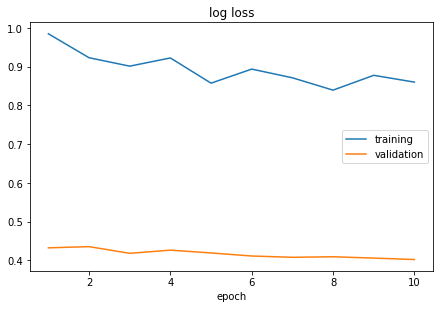

log loss:
training   (min:    0.840, max:    0.985, cur:    0.860)
validation (min:    0.403, max:    0.436, cur:    0.403)
Epoch: 132 Learning rate: 0.0025
[0/20] loss: 0.687 time:0.48
[1/20] loss: 0.733 time:0.39
[2/20] loss: 0.976 time:0.40
[3/20] loss: 0.784 time:0.40
[4/20] loss: 0.768 time:0.37


In [ ]:
trainValidateSegmentation(args)

In [ ]:
model = net.EESPNet_Seg(args.classes, s=args.s)
model_weight_file = './data/resuts/model_121.pth'
model.load_state_dict(torch.load(model_weight_file))
model = model.cuda()
# set to evaluation mode
model.eval()
print("Model OK")

In [ ]:
data = pickle.load(open(args.cached_data_file, "rb"))
args.batch_size = 1

In [ ]:
#compose the data with transforms
dataset_transformer = myTransforms.Compose([
    myTransforms.ToTensor(args.scaleIn)
])
    
valLoader = torch.utils.data.DataLoader(
    myDataLoader.MyDataset(data['valIm'], data['valAnnot'], transform=dataset_transformer),
    batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers, pin_memory=True)

trainLoader = torch.utils.data.DataLoader(
    myDataLoader.MyDataset(data['trainIm'], data['trainAnnot'], transform=dataset_transformer),
    batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers, pin_memory=True)


In [ ]:
torch.cuda.empty_cache() 
data_iter = iter(valLoader)
# data_iter = iter(trainLoader)

In [ ]:
data_t = data_iter.next()
pred = model(data_t[0].to(device=device, dtype=torch.float))
data_img = data_t[0].cpu().data.numpy()
data_msk = data_t[1].cpu().data.numpy()
data_pred = pred[0].cpu().data.numpy()

In [ ]:
imgs_msk = [data_msk[0][i] for i in range(3)]
imgs_pred = [data_pred[0][i] for i in range(3)]
imgs_rgb = [data_img[0][i] for i in range(3)]
plt.figure(figsize = (15,9))
compare(imgs_rgb + imgs_pred + imgs_msk , fig=1, rows=3, cols=3)